# MLDA Task - Train

Reference: https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from os.path import isfile, join
from shutil import copyfile

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/mldatask'
DIR_TRAIN = f'{DIR_INPUT}/robot_camera'

In [3]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(781, 8)

In [4]:
train_df['xmin'] = train_df['xmin'].astype(np.float)
train_df['xmax'] = train_df['xmax'].astype(np.float)
train_df['ymin'] = train_df['ymin'].astype(np.float)
train_df['ymax'] = train_df['ymax'].astype(np.float)

In [5]:
image_ids = [f.split('.')[0] for f in os.listdir(DIR_TRAIN) if isfile(join(DIR_TRAIN, f))]
np.random.shuffle(image_ids)
n = len(image_ids)
n

815

In [6]:
train_ids = image_ids[:int(0.9*n)]
valid_ids = image_ids[int(0.9*n):]

In [7]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [8]:
valid_df.shape, train_df.shape

((75, 8), (706, 8))

In [9]:
class MldaDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        sample_ori = {
            'image': image,
            'bboxes': target['boxes'],
            'labels': labels
        }
        
        while True:
            sample = self.transforms(**sample_ori)
            
            if len(sample['bboxes']) > 0:
                break
            
        image = sample['image']

        target['boxes'] = torch.Tensor(sample['bboxes'])
        #torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

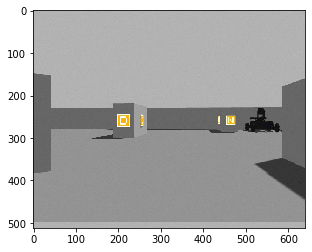

In [10]:
image = cv2.imread(f'{DIR_TRAIN}/robot_camera_0.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
plt.imshow(image)
plt.show()

In [11]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.20, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.ChannelShuffle(),
        A.Rotate(),
    
        
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [12]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [13]:
num_classes = 2  # 1 class + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [14]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MldaDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = MldaDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Visualize

In [17]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [18]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

[474 126 571 212]


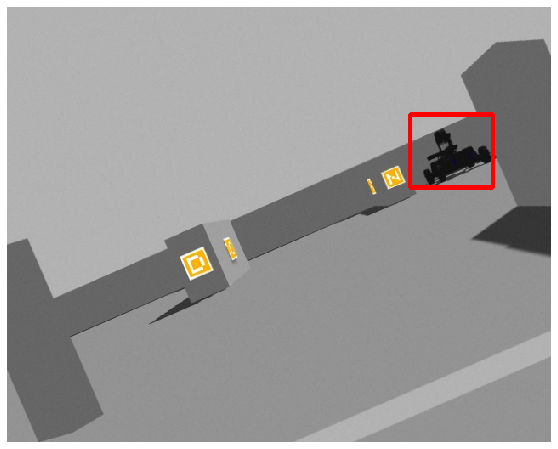

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    print(box)
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [20]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 20

In [24]:
loss_hist = Averager()
best_loss = 1e30

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    for images, targets, image_ids in valid_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)
        
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    
    if loss_hist.value < best_loss:
        torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn_epoch%d_2.pth'%epoch)
        best_loss = loss_hist.value

Epoch #0 loss: 0.03517012131799545
Epoch #1 loss: 0.031144826972324933
Epoch #2 loss: 0.03489699981374932
Epoch #3 loss: 0.02900669793598354
Epoch #4 loss: 0.03231503184153033
Epoch #5 loss: 0.029850958721778755
Epoch #6 loss: 0.03236795474575566
Epoch #7 loss: 0.029705105141536996
Epoch #8 loss: 0.02778764079890347
Epoch #9 loss: 0.030937621303434883
Epoch #10 loss: 0.035750655740100355
Epoch #11 loss: 0.030314502139974917
Epoch #12 loss: 0.028095620875579437
Epoch #13 loss: 0.03212717102308359
Epoch #14 loss: 0.0310294962754207
Epoch #15 loss: 0.029199171769765338
Epoch #16 loss: 0.030300198364005024
Epoch #17 loss: 0.03117333437382643
Epoch #18 loss: 0.031150696516436125
Epoch #19 loss: 0.031250295062948553


In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')